# Task 1

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from gensim.models import Word2Vec
import shap

## Process data

### Process members

In [3]:
members_df = pd.read_csv("members.csv", dtype={
        "msno": "category",
        "city": "category",
        "gender": "category",
        "registered_via": "category",
    })

def age_categories(row):
    if row == 0:
        row = 'UNK'
    else:
        row = row // 10
    return row

members_df.bd = members_df.bd.apply(age_categories).astype('category')
members_df.gender = members_df.gender.cat.add_categories('UNK').fillna('UNK')
members_df.registration_init_time = (members_df.registration_init_time // 100).astype('category')
members_df.expiration_date = (members_df.expiration_date // 100).astype('category')

members_df

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,UNK,UNK,7,201108,201709
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,UNK,UNK,7,201506,201706
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,UNK,UNK,4,201604,201707
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,UNK,UNK,9,201509,201509
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,UNK,UNK,4,201701,201706
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,UNK,UNK,7,201311,201709
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,1,male,3,201410,201705
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,UNK,UNK,7,201308,201709
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,UNK,UNK,7,201510,201709


### Process songs

In [4]:
songs_df = pd.read_csv("songs.csv", dtype={
        "song_id": "category",
        "genre_ids": "category",
        "artist_name": "category",
        "composer": "category",
        "lyricist": "category",
        "language": "category"
    })

song_extra_info_df = pd.read_csv("song_extra_info.csv", dtype={
        "song_id": "category",
        "name": 'string',
        "isrc": "string"
    })
    
songs_df = pd.merge(songs_df, song_extra_info_df, 'left')

songs_names = pd.DataFrame({
    'song_id': songs_df['song_id'], 
    'artist': songs_df['artist_name'],
    'name': songs_df['name'],
})

songs_df = songs_df.drop(columns=['composer', 'lyricist', 'name'])

for column in ['genre_ids', 'artist_name', 'language']:
    songs_df[column] = songs_df[column].cat.add_categories('UNK').fillna('UNK')
    
songs_df.isrc = songs_df.isrc.fillna('UNK')

def country(row):
    if row == 'UNK':
        return row
    else:
        return row[:2]

def year(row):
    if row == 'UNK':
        return row
    else:
        return row[5:7]

songs_df['country'] = songs_df.isrc.apply(country).astype('category')
songs_df['year'] = songs_df.isrc.apply(year).astype('category')
songs_df = songs_df.drop(columns=['isrc'])

In [5]:
songs_df

,song_id,song_length,genre_ids,artist_name,language,country,year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),3.0,TW,14
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,31.0,UNK,UNK
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,31.0,UNK,UNK
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,3.0,TW,02
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,52.0,UNK,UNK
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,-1.0,FR,78
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),3.0,TW,11
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,52.0,DE,15
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,52.0,US,99


### Process train

In [6]:
data = pd.read_csv("train.csv", dtype={
        "msno": "category",
        "song_id": "category",
        "source_system_tab": "category",
        "source_screen_name": "category",
        "source_type": "category"
    })

# for msno in tqdm(train_df.msno.unique()):
#     if train_df[train_df.msno == msno].shape[0] < 10:
#         train_df = train_df[train_df.msno != msno]

# for song_id in tqdm(train_df.song_id.unique()):
#     if train_df[train_df.song_id == song_id].shape[0] < 10:
#         train_df = train_df[train_df.song_id != song_id]

for column in ['source_system_tab', 'source_screen_name', 'source_type']:
    data[column] = data[column].cat.add_categories('UNK').fillna('UNK')
    
data = data.merge(members_df, on='msno', how='left').merge(songs_df, on='song_id', how='left').astype({"msno": "category", "song_id": "category"})
data = data[~data.isna().any(1)]

In [7]:
data

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,language,country,year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,UNK,UNK,7,201201,201710,206471.0,359,Bastille,52.0,GB,16
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,2,female,9,201105,201709,284584.0,1259,Various Artists,52.0,US,99
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,2,female,9,201105,201709,225396.0,1259,Nas,52.0,US,06
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,2,female,9,201105,201709,255512.0,1019,Soundway,-1.0,GB,10
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,UNK,UNK,7,201201,201710,187802.0,1011,Brett Young,52.0,QM,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,2,female,9,200412,201709,267958.0,1259,Dr. Dre,52.0,US,99
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,UNK,UNK,7,201306,201710,227404.0,465,R. City feat. Adam Levine,52.0,US,15
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,UNK,UNK,7,201306,201710,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),3.0,TW,15
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,UNK,UNK,9,201502,201709,524146.0,2122,Brad Mehldau Trio,52.0,US,07


## Training

In [8]:
train_data, val_data = train_test_split(data, shuffle=True)
train_data = train_data.sort_values("msno")
val_data = val_data.sort_values("msno")
train_users = train_data.msno.cat.codes.to_numpy()
val_users = val_data.msno.cat.codes.to_numpy()
cat_features = data.select_dtypes(["category"]).columns.to_numpy()

In [10]:
model = CatBoostRanker(
    loss_function='YetiRank',
    custom_metric='QueryAUC:type=Ranking',
    iterations=50,
    random_seed=0
)
train_pool = Pool(data=train_data.drop(columns=["target"]), label=train_data.target.values, group_id=train_users, cat_features=cat_features, has_header=True)
val_pool = Pool(data=val_data.drop(columns=["target"]), label=val_data.target.values, group_id=val_users, cat_features=cat_features, has_header=True)
model.fit(train_pool, eval_set=val_pool)
results = model.get_evals_result()

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.6305819	best: 0.6305819 (0)	total: 17.5s	remaining: 14m 16s
1:	test: 0.6319099	best: 0.6319099 (1)	total: 34.1s	remaining: 13m 37s
2:	test: 0.6319055	best: 0.6319099 (1)	total: 52.3s	remaining: 13m 39s
3:	test: 0.6419051	best: 0.6419051 (3)	total: 1m 10s	remaining: 13m 31s
4:	test: 0.6426826	best: 0.6426826 (4)	total: 1m 29s	remaining: 13m 29s
5:	test: 0.6842648	best: 0.6842648 (5)	total: 1m 51s	remaining: 13m 39s
6:	test: 0.6850961	best: 0.6850961 (6)	total: 2m 9s	remaining: 13m 14s
7:	test: 0.6837843	best: 0.6850961 (6)	total: 2m 27s	remaining: 12m 53s
8:	test: 0.6845725	best: 0.6850961 (6)	total: 2m 46s	remaining: 12m 36s
9:	test: 0.6847481	best: 0.6850961 (6)	total: 3m 4s	remaining: 12m 16s
10:	test: 0.7303448	best: 0.7303448 (10)	total: 3m 21s	remaining: 11m 55s
11:	test: 0.7300612	best: 0.7303448 (10)	total: 3m 38s	remaining: 11m 32s
12:	test: 0.7301993	best: 0.7303448 (10)	total: 3m 57s	remaining: 11m 15s
13:	test: 0.73

QueryAUC results:

Max QueryAUC = 0.5393441781994496


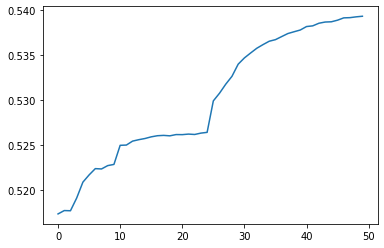

In [11]:
metrics = results['validation']['QueryAUC:type=Ranking']
print('Max QueryAUC =', max(metrics))
plt.plot(range(len(metrics)), metrics)
plt.show()

In [12]:
del model

# Task 2

## Word2vec

In [13]:
user_ids = train_data.msno.values
song_ids = train_data.song_id.values
labels = train_data.target.values

In [14]:
users_unique = np.unique(user_ids)
per_user_history = [song_ids[user_ids == user_id].tolist() for user_id in users_unique]

In [15]:
model = Word2Vec(window=10, vector_size=32, negative=18, sg=1, workers=4, min_count=2)
model.build_vocab(per_user_history)
model.train(per_user_history, total_examples=model.corpus_count, epochs=5)
song_embs = model.wv

In [16]:
user_embs = defaultdict(lambda: np.zeros(32))
for i, user_id in enumerate(users_unique):
    embs = [song_embs[song_id] for song_id in per_user_history[i] if song_id in song_embs]
    if len(embs) > 0:
        user_embs[user_id] = np.mean(np.array(embs), axis=0)

## Similars

In [17]:
songs_names[(songs_names.artist == 'Eminem') & (songs_names.name == "Lose Yourself")]

,song_id,artist,name
1381,p+WxS35GIo9lHYpW17Bz/PRW+UcGH9R+bq+wU2caYnY=,Eminem,Lose Yourself
111600,ARjGxZVGrJXEEqIXk/5+67G/nqC1FdH3AuwSQQ1m5G8=,Eminem,Lose Yourself
1447109,MSCKTsjyD7Urq/vbunDlHmc/xcFrpZ9noEbPrewKxms=,Eminem,Lose Yourself
2231614,H5vEv5ogrztWon/cj1ZacsNIJzFnQmAytb+ARVjLrA8=,Eminem,Lose Yourself


In [18]:
def show_similars(song_id):
    similars = song_embs.similar_by_vector(song_embs[song_id], topn=10)
    for similar_id, score in similars:
        similar_song = songs_names[songs_names.song_id == similar_id]
        print(f'{similar_song.artist.values[0]} - {similar_song.name.values[0]} (score = {score:.4f})')

In [19]:
show_similars('p+WxS35GIo9lHYpW17Bz/PRW+UcGH9R+bq+wU2caYnY=')

Eminem - Lose Yourself (score = 1.0000)
Eminem - Not Afraid (score = 0.9576)
Drake - Hotline Bling (score = 0.9185)
Flo Rida - Low (feat T-Pain) (score = 0.9128)
Chris Brown - Yeah 3x (score = 0.9106)
Chris Brown - Turn Up The Music (score = 0.9101)
Pitbull - Pause (score = 0.9086)
Desiigner - Panda (score = 0.9082)
Machine Gun Kelly| Camila Cabello - Bad Things (score = 0.9064)
Flo Rida - Radio (Amended Version) (score = 0.9040)


In [20]:
show_similars('1+LpXZdRvRniTDAsIw9ME5qRyInyaF2938CTIqIq20c=')

Nirvana - Smells Like Teen Spirit (score = 1.0000)
Michael Jackson - Song Groove (A/K/A Abortion Papers) (score = 0.9814)
廣告配樂精選 - One Fish in the Sea (score = 0.9808)
Tyler Ward - Locked Out Of Heaven (score = 0.9804)
High School Musical : The Concert - Breaking Free (score = 0.9803)
Ai Otsuka (大塚愛) - 恋愛写真 -春- (score = 0.9793)
舞力對決 - September (David Jones Remix Edit) - Groove Phenomenon (score = 0.9792)
讚美之泉音樂事工 (Stream of Praise Music Ministries) - 我一生要讚美祢 (score = 0.9792)
阿蘭 (alan) - Diamond (score = 0.9786)
Broods - Hold The Line (score = 0.9783)


In [21]:
show_similars('Q85XvdDDhcx6ohpVCj26yD9lWeT28fUsKSrl07hqHz4=')

Rihanna - Umbrella (score = 1.0000)
OceanLab - Lonely Girl (score = 0.9788)
Chuckie - Skydive (feat. Maiday) (score = 0.9772)
Selena Gomez - A Year Without Rain (score = 0.9725)
Tiësto - The Feeling (score = 0.9724)
Snoop Dogg - Kush Ups (feat. Wiz Khalifa) (score = 0.9702)
舞力對決 - Good Time - Flava & Stevenson ft. FreeG & Fat-k (score = 0.9696)
Zendaya - Replay (score = 0.9694)
Maria Arredondo - I need you (score = 0.9694)
Kesha - Dancing With Tears In My Eyes (score = 0.9692)


## Recommendations

In [22]:
val_user_ids = val_data.msno.values
val_song_ids = val_data.song_id.values
val_labels = val_data.target.values
assert len(val_user_ids.shape) == 1
val_scores = np.zeros_like(val_labels, dtype=float)
counter = 0
for i in tqdm(range(len(val_user_ids))):
    if val_user_ids[i] in user_embs and val_song_ids[i] in song_embs:
        counter += 1
        val_scores[i] = user_embs[val_user_ids[i]] @ song_embs[val_song_ids[i]]

100%|██████████████████████████████████████████████████████████████████████| 1844326/1844326 [00:40<00:00, 45511.69it/s]


In [23]:
counter / len(val_user_ids)

0.9573567796582599

In [24]:
roc_auc_score(val_labels, val_scores)

0.5805835980897763

## Stack

In [25]:
val_data['w2v_scores'] = val_scores

In [26]:
train_scores = np.zeros_like(labels, dtype=float)
for i in tqdm(range(len(user_ids))):
    if user_ids[i] in user_embs and song_ids[i] in song_embs:
        counter += 1
        train_scores[i] = user_embs[user_ids[i]] @ song_embs[song_ids[i]]
train_data['w2v_scores'] = train_scores

100%|██████████████████████████████████████████████████████████████████████| 5532978/5532978 [02:12<00:00, 41626.69it/s]


In [27]:
model = CatBoostRanker(
    loss_function='YetiRank',
    custom_metric='QueryAUC:type=Ranking',
    iterations=40,
    random_seed=0
)
train_pool = Pool(data=train_data.drop(columns=["target"]), label=train_data.target.values, group_id=train_users, cat_features=cat_features, has_header=True)
val_pool = Pool(data=val_data.drop(columns=["target"]), label=val_data.target.values, group_id=val_users, cat_features=cat_features, has_header=True)
model.fit(train_pool, eval_set=val_pool)
results = model.get_evals_result()

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.6609868	best: 0.6609868 (0)	total: 17.7s	remaining: 11m 31s
1:	test: 0.6671516	best: 0.6671516 (1)	total: 35.7s	remaining: 11m 18s
2:	test: 0.6681016	best: 0.6681016 (2)	total: 54.2s	remaining: 11m 8s
3:	test: 0.6681352	best: 0.6681352 (3)	total: 1m 11s	remaining: 10m 44s
4:	test: 0.6789096	best: 0.6789096 (4)	total: 1m 29s	remaining: 10m 24s
5:	test: 0.6878976	best: 0.6878976 (5)	total: 1m 46s	remaining: 10m 4s
6:	test: 0.6907436	best: 0.6907436 (6)	total: 2m 4s	remaining: 9m 44s
7:	test: 0.6911279	best: 0.6911279 (7)	total: 2m 23s	remaining: 9m 32s
8:	test: 0.6908537	best: 0.6911279 (7)	total: 2m 40s	remaining: 9m 11s
9:	test: 0.6912414	best: 0.6912414 (9)	total: 2m 57s	remaining: 8m 53s
10:	test: 0.6990085	best: 0.6990085 (10)	total: 3m 14s	remaining: 8m 34s
11:	test: 0.7206385	best: 0.7206385 (11)	total: 3m 32s	remaining: 8m 15s
12:	test: 0.7223960	best: 0.7223960 (12)	total: 3m 49s	remaining: 7m 56s
13:	test: 0.7223336	be

Max QueryAUC = 0.5415528131266453


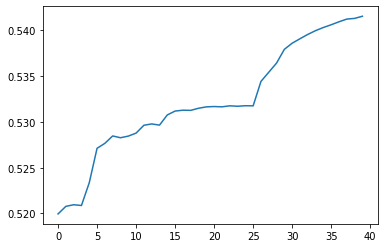

In [28]:
metrics = results['validation']['QueryAUC:type=Ranking']
print('Max QueryAUC =', max(metrics))
plt.plot(range(len(metrics)), metrics)
plt.show()

Результат немного лучше, но незначительно. Так как AUC при использовании просто similarities был 0.58, то неудивительно.

## SHAP

In [29]:
shap_data = train_data.drop(columns=["target"])[:10000]

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)

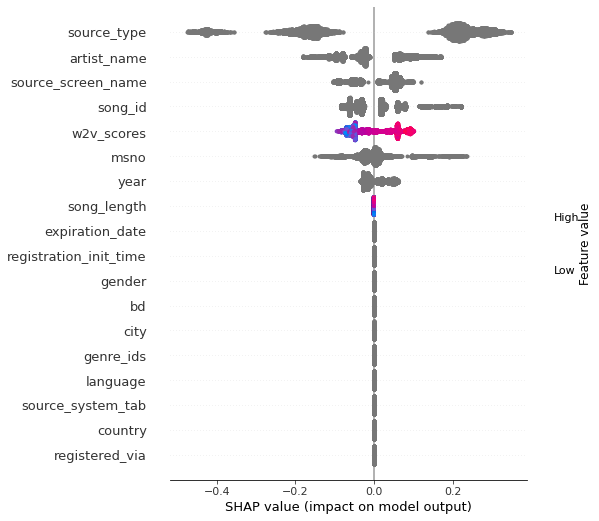

In [32]:
shap.summary_plot(shap_values, shap_data)